<a href="https://colab.research.google.com/github/amartyacodes/Final-Year-Project/blob/main/CustomModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
image_folder = '/content/drive/MyDrive/FinalYearProject/Images'
folder_name = '/content/drive/MyDrive/FinalYearProject/pickle_files'
tr_file_name = '/content/drive/MyDrive/FinalYearProject/pickle_files/train.pkl'
te_file_name = '/content/drive/MyDrive/FinalYearProject/pickle_files/test.pkl'
chexnet_weights = '/content/drive/MyDrive/FinalYearProject/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, Conv2D,Activation, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D, UpSampling2D, Multiply
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
train = pd.read_pickle(os.path.join(folder_name,tr_file_name))
test = pd.read_pickle(os.path.join(folder_name,te_file_name))
train.shape,test.shape

((4487, 8), (563, 8))

In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader


The max and min value of "caption length" was found to be 135 and 3 respectively
The 80 percentile value of caption_len which is 29 will be taken as the maximum padded value for each impression


In [ ]:

batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [ ]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_batch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place


In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [ ]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights,input_size = input_size):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,)) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-3].output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
  #since we are using attention here
  return chexnet

In [ ]:

embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [ ]:

class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data) #op shape: (None,7,7,1024)
    return op 

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, X ,name="global_flow"): #X = shape of the input
        super().__init__(name=name)
        self.matrix_shape = X[1:] #X.shape[1:]
        self.avgpooling = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.activation = Activation('relu')
        self.conv = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.upsample = UpSampling2D(size=(self.matrix_shape[1], self.matrix_shape[1]),
                                     interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operatiom
        X = self.avgpooling(X) #shape: (batch size,1,no. of filters)
        X = tf.expand_dims(tf.expand_dims(X,1),1) #op shape = batch-size*1*1*number of filters
        X = self.bn(X)
        X = self.activation(X)
        X = self.conv(X) #op shape = None*1*1*number of filters
        
        #we need to get same shape as input to this layer
        X = self.upsample(X)
        
        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, X,name="context_flow"): 
        super().__init__(name=name) #here X is shape of INP, FLOW = X[0], X[1] 
#         inp,flow = X[0], X[1] 
#         concat_ip = concatenate([inp,flow],axis=-1) #functional concatenate
#         self.matrix_shape = concat_ip.shape[1:]
        x,x1 = X[0],X[1]
        X = x[1],x[2],x[3]+x1[3]
        self.matrix_shape = X #X.shape[1:]
#         self.global_shape = flow.shape
        self.global_shape = x1[1:]
        self.concat = Concatenate(axis=-1)
        self.avgpooling = AveragePooling2D(pool_size=1,strides = self.matrix_shape[:2])
        self.bn = BatchNormalization()
        self.activation1 = Activation('relu')
        self.activation2 = Activation('relu')
        self.activation3 = Activation('sigmoid')
        self.conv1 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides=1,
                    padding="same",
                   activation = 'relu'
                    )
        self.conv2 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides=1,
                    padding="same",
                    activation = 'relu'
                    )
        self.conv3 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.conv4 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = tf.keras.layers.Conv2DTranspose( 
                            #here no. filters is equal to the no. of filters in output from global flow
                            filters = self.global_shape[-1], #output shape = (n-1)*s + k - 2*p here p=0,n=1,k=no. of filters in the input tensor
                            kernel_size = self.global_shape[:2],
                            strides=1,
                            padding="valid", 
                            activation='relu',
                            use_bias=False
                            )
        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        conc_op = self.concat([INP,FLOW])
        x = self.avgpooling(conc_op) #op_shape = batch_size*1*1*no. of filters
        # x = tf.expand_dims(tf.expand_dims(x,1),1)
        x = self.conv1(x)
        x = self.conv2(x)
        y = self.conv3(x)
        y = self.activation1(y)
        y = self.conv4(y)
        y = self.activation3(y)
        mult = self.multiply([y,x])
        add = self.add([mult,x])
        X = self.upsample(add) #shape = batch_size*inp_w*inp_h*inp
        return X #here context_flow and global_flow op willl have the same shape

In [ ]:

def encoder(image1,image2,dense_dim = dense_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  
  bkfeat1 = im_encoder(image1) #shape: (None,49,1024)
  gf = global_flow(bkfeat1.shape)
  gf_op = gf(bkfeat1)
  cf = context_flow((bkfeat1.shape,gf_op.shape))
  cf_op = cf((bkfeat1,gf_op))
  bkfeat1 = Add()([gf_op,cf_op])

  #image2
  bkfeat2 = im_encoder(image2) #shape: (None,49,1024)
  gf_op2 = gf(bkfeat2)
  cf_op2 = cf((bkfeat2,gf_op2))
  bkfeat2 = Add()([gf_op2,cf_op2])  


  #combining image1 and image2
  
  concat = Concatenate(axis=-1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,98,1024)
  concat = Dense(dense_dim,name = 'encoder_dense_final',activation = 'relu')(concat)
  op = tf.reshape(concat,(-1,concat.shape[1]*concat.shape[2],concat.shape[3]))
  bn = BatchNormalization(name = "encoder_batch_norm")(op) #(dense)#
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  return dropout

In [ ]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights

In [ ]:

glove = {}
with open('/content/drive/MyDrive/FinalYearProject/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [ ]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                weights = [embedding_matrix],
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,
                    # return_sequences=True,
                    return_state=True,
                    name = 'onestepdecoder_LSTM'
                    )
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = Concatenate(axis=-1)
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    # embedding_op = self.dense(embedding_op)

    context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
    #now we will combine arrention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
   

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights #decoder_c,

In [ ]:
class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_pad, embedding_dim = embedding_dim,dense_dim = dense_dim,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32,size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32,size=max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      # output,decoder_h,decoder_c,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h,decoder_c)
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep,output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array

In [ ]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))

encoder_output = encoder(image1,image2) #shape: (None,28,512)

output = decoder()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

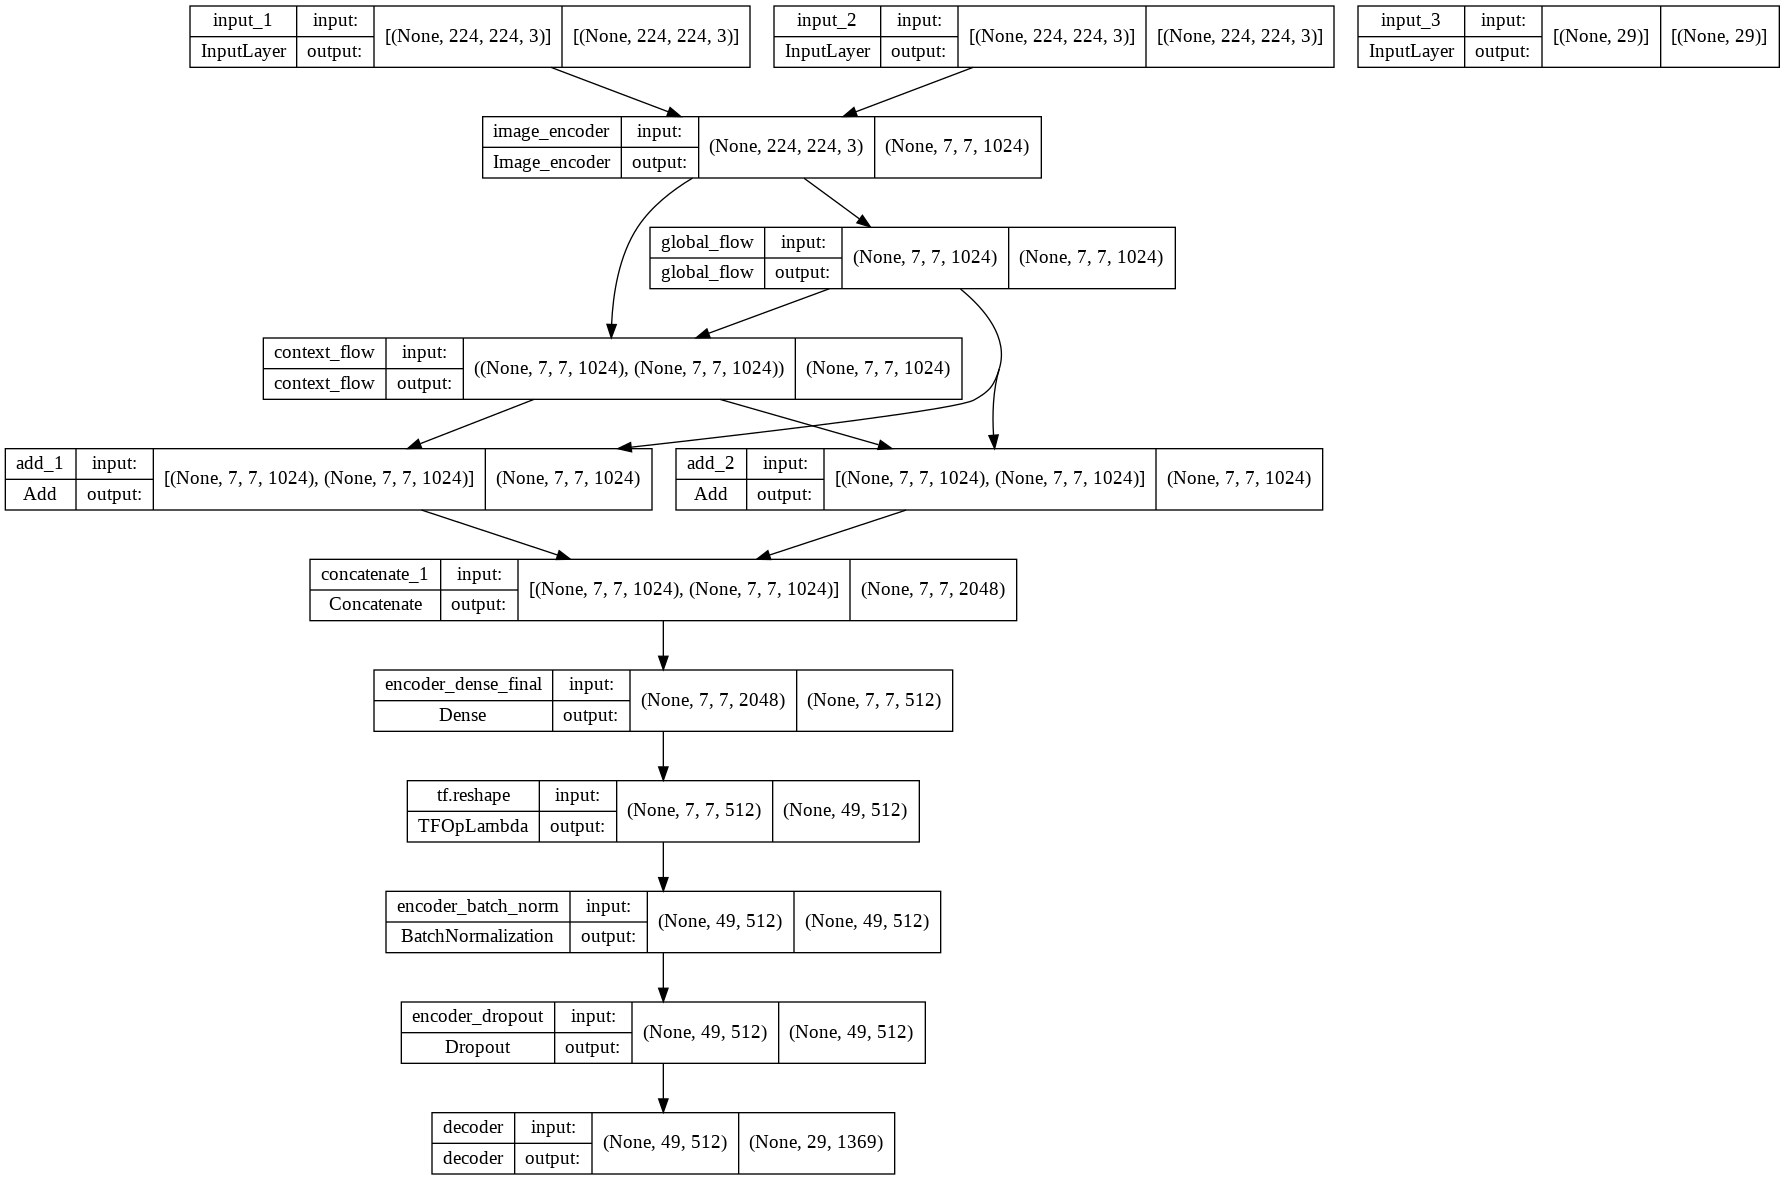

In [ ]:

tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-2
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Encoder_Decoder_global_attention_custom_model/'
tb_file = os.path.join('/content/drive/MyDrive/FinalYearProject',tb_filename)
model_filename = 'Encoder_Decoder_global_attention_custom_model.h5'
model_save = os.path.join('/content/drive/MyDrive/FinalYearProject',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )

Layer global_flow has arguments ['self', 'X']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 3.4322 - accuracy: 0.5145
Epoch 1: val_loss improved from inf to 2.42501, saving model to /content/drive/MyDrive/FinalYearProject/Encoder_Decoder_global_attention_custom_model.h5
